# Data Science Group Project Report 006-021
## Heart Disease Hungarian Data:
##### Members: 
- Jaden Lai (79465795)
- Percy Pham (70210562)
- Sydney Trim (86059649)

#### Introduction:
Heart disease is a leading cause of death worldwide associated with many variables. This project aims to identify patients most likely to experience heart problems by analyzing age, sex, resting blood pressure, resting electrocardiographic results, and fasting blood sugar. To answer this question we will be analyzing the Heart Disease Data Set from the Hungarian Institute of Cardiology. This dataset provides fourteen attributes. However, we have selected eight of them to find an answer to our question.

#### Question: 
What patients are most likely to experience heart problems (chest pain, heart disease) using predictors of age, sex, resting blood pressure, resting electrocardiographic results, and fasting blood sugar?

In [8]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

### Methods & Results

##### Downloading the data, cleaning the table

In [17]:
# Downloading the data, cleaning the table

download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", "project.csv")
heart_disease_hungarian <- read_csv("project.csv", col_names = FALSE)
colnames(heart_disease_hungarian) <- c("age", "sex", "chest_pain", "resting_blood_pressure", "cholesterol",
                                       "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", 
                                       "exercise_induced_angina", "ST_depression",
                                       "slope_of_peak_exercise_ST_segment",
                                       "number_of_major_vessels", "thalassemia", "heart_disease_cases") 

heart_disease_hungarian <- heart_disease_hungarian |>
            select(age, sex, resting_blood_pressure, fasting_blood_sugar,
                   resting_electrocardiographic_results, heart_disease_cases) |>
             mutate(resting_blood_pressure = as.numeric(resting_blood_pressure)) |>
             mutate(sex = as_factor(sex)) |>
             mutate(fasting_blood_sugar = as_factor(fasting_blood_sugar)) |>
             mutate(resting_electrocardiographic_results = as_factor(resting_electrocardiographic_results)) |>
             mutate(heart_disease_cases = as_factor(heart_disease_cases))
             


heart_disease_hungarian_summarize <- heart_disease_hungarian |>
            group_by(age,sex)


heart_disease_hungarian
heart_disease_hungarian_summarize
tail(heart_disease_hungarian_summarize, 5)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,resting_blood_pressure,fasting_blood_sugar,resting_electrocardiographic_results,heart_disease_cases
<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
28,1,130,0,2,0
29,1,120,0,0,0
29,1,140,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮
56,1,155,1,0,1
58,0,180,0,0,1
65,1,130,0,1,1


age,sex,resting_blood_pressure,fasting_blood_sugar,resting_electrocardiographic_results,heart_disease_cases
<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
28,1,130,0,2,0
29,1,120,0,0,0
29,1,140,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮
56,1,155,1,0,1
58,0,180,0,0,1
65,1,130,0,1,1


age,sex,resting_blood_pressure,fasting_blood_sugar,resting_electrocardiographic_results,heart_disease_cases
<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
52,1,160,0,0,1
54,0,130,0,1,1
56,1,155,1,0,1
58,0,180,0,0,1
65,1,130,0,1,1


##### Variable Explenation:
- Sex: 1 = Male, 0 = Female
- Resting blood pressure: mmHg
- Fasting blood sugar, 1 = >120 mg/dl, 2 = <=120 mg/dl
- Resting electrocardiographic result: 0 = Normal, 1 = Having ST-Twave abnormality, 2 = Showing probable or definite left ventricular hypertrophy

##### Summary table 
Organizing our data table, we can make an inference that heart disease cases are mostly found in older males around the age of 45-55. From our table, we can observe that the top five most frequent cases of heart disease with the same sex, age, and chest pain, are all of the male sex of ages 46 to 52.

##### Training and testing
We are using 75% of our data to split into training and testing data to predict heart disease cases.

In [18]:
set.seed(27)
hd_split <- initial_split(heart_disease_hungarian, prop = 0.75, strata = heart_disease_cases)
hd_train <- training(hd_split)   
hd_test <- testing(hd_split)

hd_train
hd_test

age,sex,resting_blood_pressure,fasting_blood_sugar,resting_electrocardiographic_results,heart_disease_cases
<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
29,1,120,0,0,0
29,1,140,0,0,0
30,0,170,0,1,0
⋮,⋮,⋮,⋮,⋮,⋮
56,1,155,1,0,1
58,0,180,0,0,1
65,1,130,0,1,1


age,sex,resting_blood_pressure,fasting_blood_sugar,resting_electrocardiographic_results,heart_disease_cases
<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
28,1,130,0,2,0
32,0,105,0,0,0
34,0,130,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮
53,1,145,0,0,1
55,1,140,0,?,1
50,1,140,0,1,1


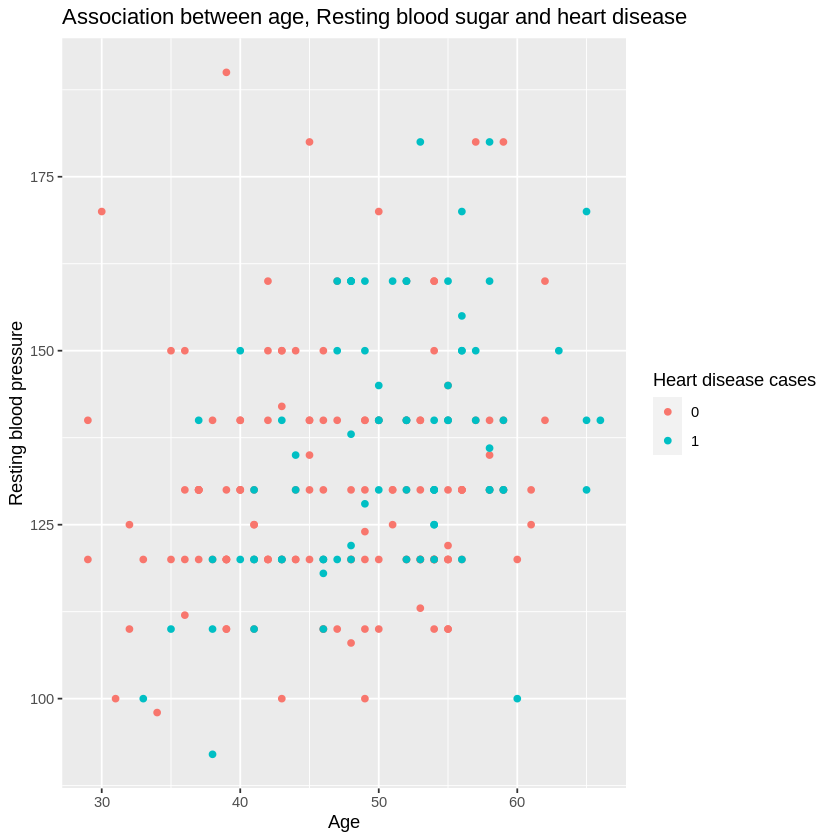

In [19]:
# your code here
heart_disease_plot <- hd_train |>
    ggplot(aes(x = age, y = resting_blood_pressure, color = heart_disease_cases)) + 
        geom_point() +
        labs(x = "Age", y = "Resting blood pressure", color = "Heart disease cases", title = "Association between age, Resting blood sugar and heart disease")

heart_disease_plot <- heart_disease_plot + 
       scale_fill_brewer(palette = "YlOrRd")
heart_disease_plot

In [22]:
# create an empty tibble to store the results
names <- colnames(hd_train |> select(-heart_disease_cases))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
heart_disease_vfold <- vfold_cv(hd_train, v = 5, strata = heart_disease_cases)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("heart_disease_cases", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_disease_recipe <- recipe(as.formula(model_string), 
                                data = hd_split) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_disease_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_disease_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

x Fold1: preprocessor 1/1:
  Error in `check_type()`:
  ! All columns selected for the step should be numeric

x Fold2: preprocessor 1/1:
  Error in `check_type()`:
  ! All columns selected for the step should be numeric

x Fold3: preprocessor 1/1:
  Error in `check_type()`:
  ! All columns selected for the step should be numeric

x Fold4: preprocessor 1/1:
  Error in `check_type()`:
  ! All columns selected for the step should be numeric

x Fold5: preprocessor 1/1:
  Error in `check_type()`:
  ! All columns selected for the step should be numeric

Warning message:
“All models failed. Run `show_notes(.Last.tune.result)` for more information.”


ERROR: [1m[33mError[39m in [1m[1m`estimate_tune_results()`:[22m
[33m![39m All of the models failed. See the .notes column.


##### Explanation of Data Graph:
From reading the graph there seems to be no real relationship between the variables blood pressure and heart disease. Patients diagnosed with heart disease are predominantly found within the age range of 45-60 hence, we can establish the connection between age and heart disease cases.

### Methods:
We will begin our data analysis cleaning and wrangling the dataset we have chosen. We aim to find our answer by utilizing scatterplots for the predictors we have chosen for the scope of this project. Forementioned, we have chosen eight of the fourteen attributes of the data set: age, sex, resting blood pressure, resting electrocardiographic results, fasting blood sugar, chest pain, and heart disease. Studies support that our chosen predictors have associations with cardiovascular heart disease but the extent of each is still unknown. 

### Expected Outcomes and Significance:

#### What do we expect to find: 
We expect to find associations between heart disease with our chosen predictors. Based on our findings we will be able to identify the most telltale variable for heart disease as well as the relationship predictors may have with one another. We can expect heart disease risk and diagnosis to increase with age, but the same could not be said for the other predictors.

#### What impact do such findings have:
Our findings will contribute to identifying portions of the population at higher risk for heart disease based on our predictor variables. This research is done to advocate for health and prevention and to contribute to the current knowledge we have on heart disease.

#### What future questions could this lead to: 
Our project leads to many future questions: How can we prevent it within the population, especially if the community doesn't necessarily have the resources for prevention? Also, what other variables other than the ones we have tested could lead to being predisposed to heart disease? Lastly, how much control do patients have over their risk for heart disease and how can they prevent heart disease with this new information?

### Discussion:

#### References
- Ashley, E. A., Raxwal, V., & Froelicher, V. (2001). An evidence-based review of the resting electrocardiogram as a screening technique for heart disease. Progress in Cardiovascular Diseases, 44(1), 55–67. https://doi.org/10.1053/pcad.2001.24683
- He, K., Chen, X., Shi, Z., Shi, S., Tian, Q., Hu, X., Song, R., Bai, K., Shi, W., Wang, J., Li, H., Ding, J., Geng, S., & Sheng, X. (2022). Relationship of resting heart rate and blood pressure with all-cause and cardiovascular disease mortality. Public Health, 208, 80–88. https://doi.org/10.1016/j.puhe.2022.03.020 
- Maas, A. H. E. M., & Appelman, Y. E. A. (2010). Gender differences in coronary heart disease. Netherlands Heart Journal, 18(12), 598–603. https://doi.org/10.1007/s12471-010-0841-y
- Moran, A. E., Tzong, K. Y., Forouzanfar, M. H., Roth, G. A., Mensah, G. A., Ezzati, M., Murray, C. J. L., & Naghavi, M. (2014). Variations in ischemic heart disease burden by age, country, and income: the global burden of diseases, injuries, and risk factors 2010 study. Global Heart, 9(1), 91. https://doi.org/10.1016/j.gheart.2013.12.007 
- Park, C., Guallar, E., Linton, J. A., Lee, D.-C., Jang, Y., Son, D. K., Han, E.-J., Baek, S. J., Yun, Y. D., Jee, S. H., & Samet, J. M. (2013). Fasting glucose level and the risk of incident atherosclerotic cardiovascular diseases. Diabetes Care, 36(7), 1988–1993. https://doi.org/10.2337/dc12-1577 